In [65]:
### Importing packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../python')
from earfcn_to_freq import earfcn_to_freq
from haversine import haversine
from calc_bearing import calc_bearing
from gain_calc import gain_calc

### Data Preprocesing

df = pd.read_csv('../data/qualipoc_data/cbrs_radio_2024_oct_nov.csv', sep=";")
df.rename(columns={'PCI/PSC/BSIC': 'PCI'}, inplace=True)
df['Frequency'] = df['DL EARFCN'].apply(earfcn_to_freq)
df = df[df['DL Bandwidth'] == 20]
df.drop(columns=['Date', 'Time', 'Device Name', 'Carrier Index', 'Technology Band', 'Band Number', 'DL EARFCN', 'SCC Index', 'TxAntennas',\
                 'Frequency Number', 'DL Subcarrier Spacing', 'DL Carriers Radio', 'Cell Id', 'eNB-Id', 'Sector Id', 'Operator', 'DL Bandwidth'], inplace=True)

pci_map = {
    0: { 'BS': 1, 'Latitude': 41.65425, 'Longitude': -86.242694, 'Azimuth': 60, 'Downtilt': 4, 'Height': 21, 'Frequency': 3670 },
    3: { 'BS': 1, 'Latitude': 41.65425, 'Longitude': -86.242694, 'Azimuth': 120, 'Downtilt': 4, 'Height': 21, 'Frequency': 3640 },
    6: { 'BS': 1, 'Latitude': 41.65425, 'Longitude': -86.24375, 'Azimuth': 180, 'Downtilt': 4, 'Height': 21, 'Frequency': 3580 },
    9: { 'BS': 1, 'Latitude': 41.65425, 'Longitude': -86.24375, 'Azimuth': 240, 'Downtilt': 4, 'Height': 21, 'Frequency': 3690 },
    12: { 'BS': 1, 'Latitude': 41.654639, 'Longitude': -86.24375, 'Azimuth': 300, 'Downtilt': 4, 'Height': 29, 'Frequency': 3560 },
    15: { 'BS': 1, 'Latitude': 41.654639, 'Longitude': -86.24375, 'Azimuth': 0, 'Downtilt': 4, 'Height': 29, 'Frequency': 3580 },
    18: { 'BS': 4, 'Latitude': 41.668678, 'Longitude': -86.312222, 'Azimuth': 70, 'Downtilt': -1, 'Height': 12, 'Frequency': 3690 },
    21: { 'BS': 4, 'Latitude': 41.668678, 'Longitude': -86.312222, 'Azimuth': 130, 'Downtilt': -1, 'Height': 12, 'Frequency': 3640 },
    24: { 'BS': 2, 'Latitude': 41.663278, 'Longitude': -86.254139, 'Azimuth': 60, 'Downtilt': 4, 'Height': 44, 'Frequency': 3670 },
    27: { 'BS': 2, 'Latitude': 41.663278, 'Longitude': -86.254139, 'Azimuth': 120, 'Downtilt': 4, 'Height': 44, 'Frequency': 3640 },
    30: { 'BS': 2, 'Latitude': 41.663278, 'Longitude': -86.254139, 'Azimuth': 180, 'Downtilt': 4, 'Height': 44, 'Frequency': 3580 },
    33: { 'BS': 2, 'Latitude': 41.663278, 'Longitude': -86.254139, 'Azimuth': 240, 'Downtilt': 4, 'Height': 44, 'Frequency': 3690 },
    36: { 'BS': 2, 'Latitude': 41.663278, 'Longitude': -86.254139, 'Azimuth': 300, 'Downtilt': 4, 'Height': 44, 'Frequency': 3560 },
    39: { 'BS': 2, 'Latitude': 41.663278, 'Longitude': -86.254139, 'Azimuth': 0, 'Downtilt': 4, 'Height': 44, 'Frequency': 3580 },
    42: { 'BS': 3, 'Latitude': 41.67225, 'Longitude': -86.292778, 'Azimuth': 120, 'Downtilt': 4, 'Height': 33, 'Frequency': 3670 },
    45: { 'BS': 3, 'Latitude': 41.67225, 'Longitude': -86.292778, 'Azimuth': 180, 'Downtilt': 4, 'Height': 33, 'Frequency': 3640 },
    48: { 'BS': 3, 'Latitude': 41.67225, 'Longitude': -86.292778, 'Azimuth': 240, 'Downtilt': 4, 'Height': 33, 'Frequency': 3690 },
    51: { 'BS': 3, 'Latitude': 41.67225, 'Longitude': -86.292778, 'Azimuth': 300, 'Downtilt': 4, 'Height': 33, 'Frequency': 3580 },
}
df_pci_map = pd.DataFrame.from_dict(pci_map, orient='index').reset_index()
df_pci_map.rename(columns={'index': 'PCI'}, inplace=True)
del pci_map

df = df.merge(df_pci_map[['PCI', 'BS', 'Latitude', 'Longitude', 'Azimuth', 'Downtilt', 'Height']], on='PCI', how='left')
df.rename(columns={'Latitude_x': 'ue_Latitude', 'Latitude_y': 'bs_Latitude', 'Longitude_x': 'ue_Longitude', 'Longitude_y': 'bs_Longitude',\
                   'Azimuth': 'bs_Azimuth', 'Downtilt': 'bs_Downtilt', 'Height': 'bs_Height'}, inplace=True)
del df_pci_map

df_antenna = pd.read_csv('../data/antenna.csv')

df[['Distance_2d', 'Distance_3d']] = df.apply(lambda row: haversine(row['ue_Latitude'], row['ue_Longitude'],
                                                                    row['bs_Latitude'], row['bs_Longitude'], row['bs_Height']), axis=1, result_type='expand')
df['Distance_3d_log'] = 10 * np.log10(df['Distance_3d'])
df['Distance_3d_log'] = 10 * np.log10(df['Distance_3d'])
df['ue_Elevation'] = 90 - np.rad2deg(np.arctan(df['bs_Height'] / df['Distance_2d']))

df['ue_Azimuth'] = df.apply(lambda row: calc_bearing(row['bs_Latitude'], row['bs_Longitude'], row['ue_Latitude'], row['ue_Longitude'], row['bs_Azimuth']), axis=1)

df[['gain_Azimuth', 'gain_Elevation']] = 20.5 * df.apply(lambda row: pd.Series(gain_calc(df_antenna, row['ue_Azimuth'], row['ue_Elevation'])), axis=1)
# It is not 20Mhz/15khz as there are 100 PRBs in 20Mhz conf (rest are guard bands)
df['bs_Power'] = 29.5 + (df['gain_Azimuth']*df['gain_Elevation']/20.5) - 10*np.log10(1200)

del df_antenna

df = df[df['BS'].isin([3, 4])]

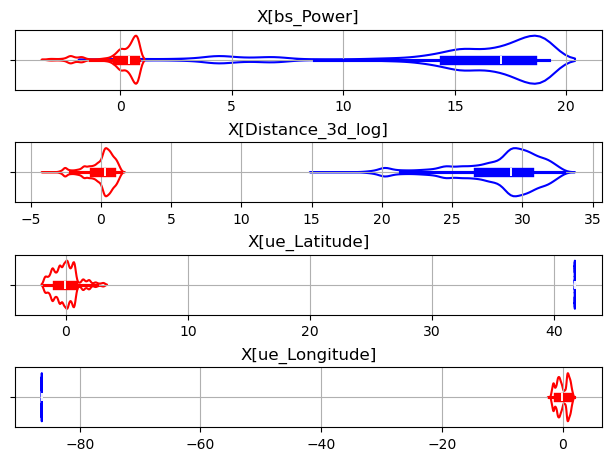

In [66]:
# X_linD = df[['bs_Power', 'Distance_3d']].values
# X_linD_gps = df[['bs_Power', 'Distance_3d', 'ue_Latitude', 'ue_Longitude']].values
X_logD = df[['bs_Power', 'Distance_3d_log']].values
X_logD_gps = df[['bs_Power', 'Distance_3d_log', 'ue_Latitude', 'ue_Longitude']].values
Y = df['RSRP'].values

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_logD_gps_scaled = scaler.fit_transform(X_logD_gps)

fig, axes = plt.subplots(4, 1, figsize=(6, 4.5), layout='constrained')
for i, column in enumerate(['bs_Power', 'Distance_3d_log', 'ue_Latitude', 'ue_Longitude']):
    sns.violinplot(ax=axes[i], x=X_logD_gps[:, i], fill=False, color='blue')
    sns.violinplot(ax=axes[i], x=X_logD_gps_scaled[:, i], fill=False, color='red')
    axes[i].set_title(f'X[{column}]')
    axes[i].grid(True)

del scaler, X_logD_gps_scaled, i, fig, axes, column

In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_logD_train, X_logD_test, Y_logD_train, Y_logD_test = train_test_split(X_logD, Y, test_size=0.2, random_state=42)
X_logD_gps_train, X_logD_gps_test, Y_logD_gps_train, Y_logD_gps_test = train_test_split(X_logD_gps, Y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_logD_train = scaler.fit_transform(X_logD_train)
X_logD_test = scaler.transform(X_logD_test)
X_logD_gps_train = scaler.fit_transform(X_logD_gps_train)
X_logD_gps_test = scaler.transform(X_logD_gps_test)

model_no_gps = Sequential([
    Dense(128, activation='relu', input_shape=(X_logD_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])
model_no_gps.compile(optimizer='adam', loss='mse', metrics=['mae'])

model_gps = Sequential([
    Dense(128, activation='relu', input_shape=(X_logD_gps_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])
model_gps.compile(optimizer='adam', loss='mse', metrics=['mae'])

print("Training model_no_gps...")
history_no_gps = model_no_gps.fit(X_logD_train, Y_logD_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)
print("Training model_gps...")
history_gps = model_gps.fit(X_logD_gps_train, Y_logD_gps_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

Training model_no_gps...
Epoch 1/20
771/771 [==============================] - 2s 2ms/step - loss: 1175.0856 - mae: 18.1751 - val_loss: 59.2668 - val_mae: 5.8106
Epoch 2/20
771/771 [==============================] - 1s 2ms/step - loss: 53.7773 - mae: 5.6114 - val_loss: 53.0022 - val_mae: 5.5332
Epoch 3/20
771/771 [==============================] - 2s 2ms/step - loss: 51.1659 - mae: 5.4904 - val_loss: 51.9152 - val_mae: 5.5430
Epoch 4/20
771/771 [==============================] - 1s 2ms/step - loss: 49.7148 - mae: 5.4289 - val_loss: 49.6955 - val_mae: 5.4140
Epoch 5/20
771/771 [==============================] - 1s 2ms/step - loss: 48.8930 - mae: 5.3915 - val_loss: 49.3297 - val_mae: 5.4500
Epoch 6/20
771/771 [==============================] - 1s 2ms/step - loss: 48.2542 - mae: 5.3742 - val_loss: 50.5313 - val_mae: 5.6633
Epoch 7/20
771/771 [==============================] - 1s 2ms/step - loss: 48.0163 - mae: 5.3687 - val_loss: 48.4739 - val_mae: 5.3717
Epoch 8/20
771/771 [==============

In [68]:
print("\nEvaluating model_no_gps...")
loss, mae = model_no_gps.evaluate(X_logD_test, Y_logD_test)
print(f"MAE on test data: {mae:.2f}")

print("\nEvaluating model_gps...")
loss, mae = model_gps.evaluate(X_logD_gps_test, Y_logD_gps_test)
print(f"MAE on test data: {mae:.2f}")


Evaluating model_no_gps...
241/241 [==============================] - 0s 2ms/step - loss: 45.3596 - mae: 5.0728
MAE on test data: 5.07

Evaluating model_gps...
241/241 [==============================] - 0s 1ms/step - loss: 24.2713 - mae: 3.7523
MAE on test data: 3.75


In [ ]:
predictions_no_gps = model_no_gps.predict(X_logD_train)
predictions_gps = model_gps.predict(X_logD_gps_train)

print("\nSample predictions for model_no_gps:")
for i in range(5):
    print(f"Actual: {Y_logD_test[i]}, Predicted: {predictions_no_gps[i][0]:.2f}")

print("\nSample predictions for model_gps:")
for i in range(5):
    print(f"Actual: {Y_logD_gps_test[i]}, Predicted: {predictions_gps[i][0]:.2f}")



964/964 [==============================] - 5s 5ms/step

Sample predictions for model_no_gps:
Actual: -130.6, Predicted: -106.24
Actual: -105.4, Predicted: -104.05
Actual: -97.2, Predicted: -113.30
Actual: -90.6, Predicted: -111.31
Actual: -108.0, Predicted: -108.96

Sample predictions for model_gps:
Actual: -130.6, Predicted: -98.94
Actual: -105.4, Predicted: -109.88
Actual: -97.2, Predicted: -106.71
Actual: -90.6, Predicted: -107.25
Actual: -108.0, Predicted: -106.19


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_65 (Dense)            (None, 128)               384       
                                                                 
 dense_66 (Dense)            (None, 64)                8256      
                                                                 
 dense_67 (Dense)            (None, 32)                2080      
                                                                 
 dense_68 (Dense)            (None, 1)                 33        
                                                                 
Total params: 10,753
Trainable params: 10,753
Non-trainable params: 0
_________________________________________________________________


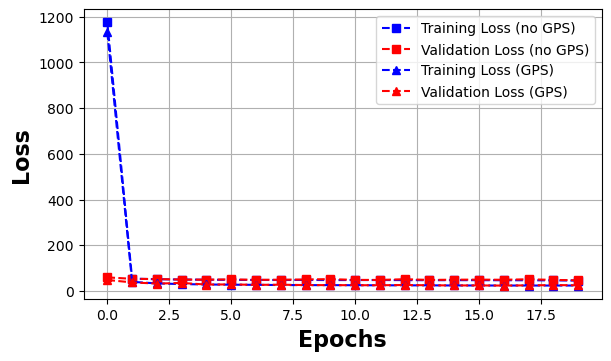

In [ ]:
model_no_gps.summary()

history_no_gps = history_no_gps.history
history_gps = history_gps.history
plt.figure(figsize=(6, 3.5), layout='constrained')
plt.plot(history_no_gps['loss'], label='Training Loss (no GPS)', linestyle='--', marker='s', color='blue')
plt.plot(history_no_gps['val_loss'], label='Validation Loss (no GPS)', linestyle='--', marker='s', color='red')
plt.plot(history_gps['loss'], label='Training Loss (GPS)', linestyle='--', marker='^', color='blue')
plt.plot(history_gps['val_loss'], label='Validation Loss (GPS)', linestyle='--', marker='^', color='red')
plt.xlabel('Epochs', fontsize=16, fontweight='bold')
plt.ylabel('Loss', fontsize=16, fontweight='bold')
plt.legend()
plt.grid()
plt.show()